# PyTorch CNN – FashionMNIST Classification

## Objective

This notebook demonstrates a **Convolutional Neural Network (CNN)** built with PyTorch
to classify images from the **FashionMNIST** dataset.

The focus is on:
- Clean project structure
- Modular training and evaluation
- Proper use of PyTorch and DataLoaders
- Visualization of training performance


## Imports & Setup

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import pandas as pd

# Import project modules
from src.model import FashionMNISTCNN
from src.training import train_step
from src.evaluate import test_step, eval_model
from src.utils import accuracy_fn, set_seed, plot_predictions, plot_confusion_matrix

## Device & Reproducibility

In [10]:
# Set random seed for reproducibility
set_seed(42)

# Device-agnostic setup
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## Dataset & Transforms

>We define a transformation pipeline to prepare the FashionMNIST images for the neural network. This includes converting images to tensors and normalizing pixel values to a range of $[-1, 1]$ to improve training stability.

In [11]:
# Image transformations
# We scale pixels to [0, 1] then normalize them around a mean of 0.5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST dataset
train_data = datasets.FashionMNIST(
    root="data",            # Folder where the images are stored
    train=True,             # Load the 60,000 training images
    download=True,          # Download the data if it's not already in the 'root' folder
    transform=transform     # Apply the transformations defined above
)

test_data = datasets.FashionMNIST(
    root="data",            # Use the same root folder
    train=False,            # Load the 10,000 test images
    download=True,          # Ensure test data is also downloaded
    transform=transform     # Use the EXACT same transform as the training data
)

## DataLoader Setup

In [12]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Train batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Train batches: 1875
Test batches: 313


## Class Names & Data Inspection

In [13]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

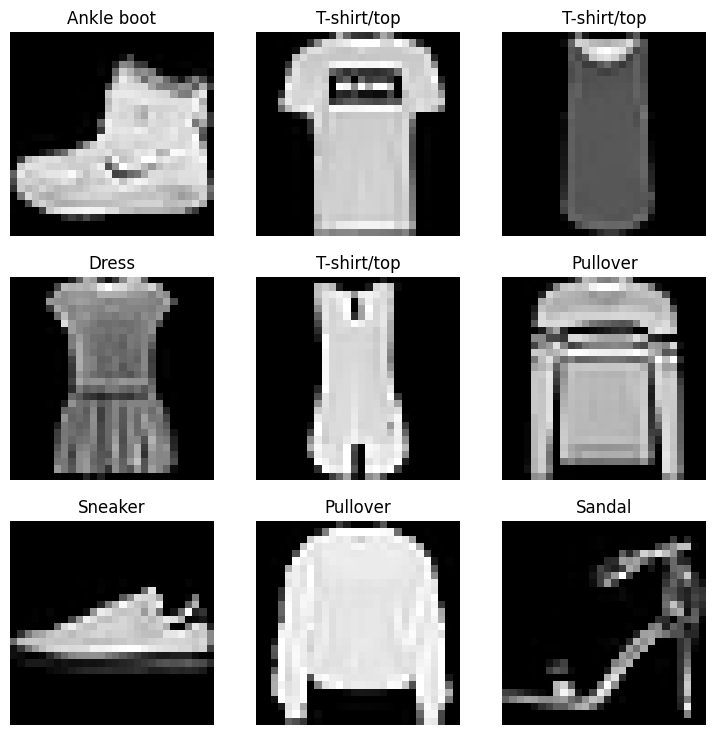

In [16]:
# Visualize sample images
plt.figure(figsize=(9,9))
for i in range(9):
    image, label = train_data[i]
    plt.subplot(3,3,i+1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis("off")
plt.savefig("../images/Sample_images.png")
plt.show()

## Model Initialization

In [17]:
model = FashionMNISTCNN(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)

model

FashionMNISTCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Loss Function & Optimizer

In [18]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=0.001)

## Training Loop

In [19]:
EPOCHS = 10

train_loss_list, train_acc_list = [], []
test_loss_list, test_acc_list = [], []

# Train and test model
for epoch in range(EPOCHS):
    print(f'Epoch {epoch}\n-----')

    train_loss, train_acc = train_step(
        model=model,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device)

    test_loss, test_acc = test_step(
        model=model,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device)

    train_loss_list.append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    test_acc_list.append(test_acc)

Epoch 0
-----
Test loss: 0.40325 | Test accuracy: 85.29% 

Epoch 1
-----
Test loss: 0.34312 | Test accuracy: 87.78% 

Epoch 2
-----
Test loss: 0.33754 | Test accuracy: 87.47% 

Epoch 3
-----
Test loss: 0.31532 | Test accuracy: 88.64% 

Epoch 4
-----
Test loss: 0.31302 | Test accuracy: 88.77% 

Epoch 5
-----
Test loss: 0.29535 | Test accuracy: 89.60% 

Epoch 6
-----
Test loss: 0.28950 | Test accuracy: 89.37% 

Epoch 7
-----
Test loss: 0.29121 | Test accuracy: 89.69% 

Epoch 8
-----
Test loss: 0.27965 | Test accuracy: 90.01% 

Epoch 9
-----
Test loss: 0.26748 | Test accuracy: 90.45% 



## Training Curves Visualization

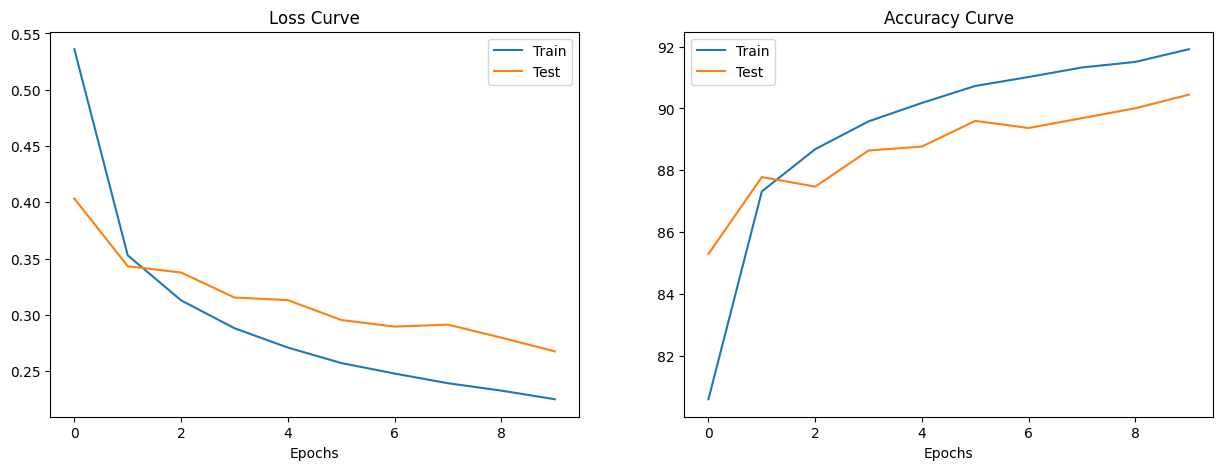

<Figure size 640x480 with 0 Axes>

In [20]:
epochs_range = range(EPOCHS)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
ax1.plot(train_loss_list, label="Train")
ax1.plot(test_loss_list, label="Test")
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epochs")
ax1.legend()

# Plot Accuracy
ax2.plot(train_acc_list, label="Train")
ax2.plot(test_acc_list, label="Test")
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epochs")
ax2.legend()

plt.show()
plt.savefig("../images/training_curves.png")

## Model Evaluation & Predictions

In [21]:
# ## Final Model Evaluation
# We evaluate the model on the full test dataset to get final performance metrics.
# Evaluate model and capture predictions/targets for the confusion matrix
results = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
    return_preds=True  # Crucial for the next steps
)

# Display the results dictionary
results_df = pd.DataFrame([results])
print(results_df[["model_name", "model_loss", "model_accuracy"]])

        model_name  model_loss  model_accuracy
0  FashionMNISTCNN    0.267481       90.445288


Plot saved to ../images/predictions.png


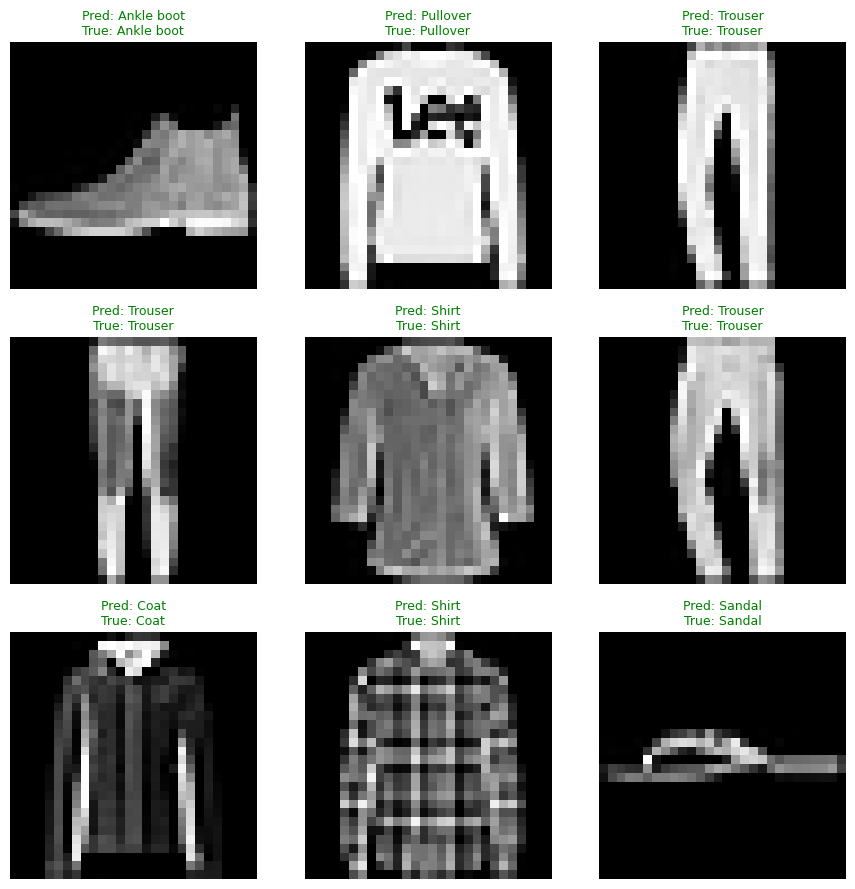

In [22]:
# ## Visualizing Sample Predictions
# Using the utility function to visualize random samples and compare predictions vs. ground truth.
# We can pass a lambda to denormalize if we want to see the original pixel intensities
# but for FashionMNIST gray-scale, standard squeeze usually looks fine.
plot_predictions(
    model=model,
    dataloader=test_dataloader,
    class_names=class_names,
    device=device,
    n_images=9,
    save_path="../images/predictions.png"
)

Confusion Matrix saved to ../images/confusion_matrix.png


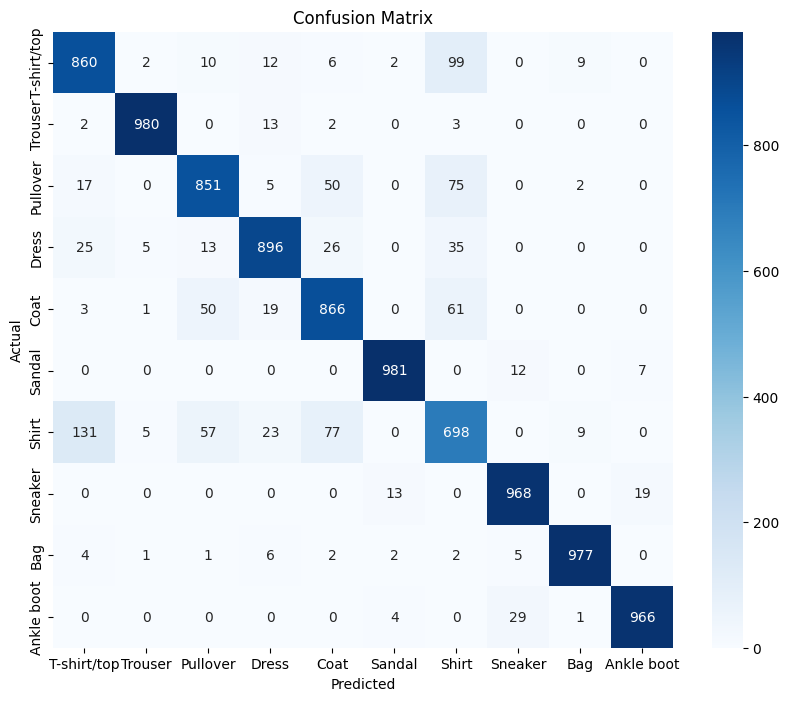

In [23]:
# ## Confusion Matrix
# A detailed look at which classes the model confuses most often.
# We use the 'preds' and 'targets' stored in our results dictionary earlier
plot_confusion_matrix(
    preds=results["preds"],
    targets=results["targets"],
    class_names=class_names,
    save_path="../images/confusion_matrix.png"
)

## Conclusion

- A CNN significantly outperforms linear models on image data
- Modular code structure improves readability and reusability
- PyTorch DataLoaders and training loops enable scalable training
- This project demonstrates a clean, production-oriented CNN workflow
